# Classificação de Doenças Cardíacas

## Objetivos

Desenvolver um classificador binário para predição de doenças cardíacas usando Redes Neurais Artificiais.

### Especificações Técnicas

- **Arquitetura:** Feedforward com 2 camadas ocultas
- **Ativações:** ReLU (ocultas), Sigmoid (saída)
- **Regularização:** Dropout + L2 + Early Stopping
- **Classificação:** Binária (0=saudável, 1=doente)
- **Métricas:** Acurácia, Precisão, Recall, Matriz de Confusão

### Dataset

- **Fonte:** UCI Cleveland Heart Disease Database
- **Amostras:** 303 → 297 (após limpeza)
- **Features:** 13 atributos clínicos
- **Balanceamento:** 53.87% saudáveis, 46.13% doentes

---

**Autores:** Alexandre Pereira de Souza Junior, João Pedro Castro das Virgens, Leonardo Brandão do Amarante, Mateus Rodrigues Cavalcante, Vithor Junior da Encarnação Vitório  
**Disciplina:** Fundamentos de Inteligência Artificial  
**Instituição:** Universidade Federal do Amazonas (UFAM)  
**Professor:** Edjard Mota

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-11-15 15:34:13.852313: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 15:34:13.858843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-15 15:34:14.155122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 15:34:15.407588: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Fase 1: Exploração dos Dados

Carregamento do dataset direto da UCI, limpeza de valores nulos, transformação do target para binário e análise de correlações.

---

In [2]:
url_uci = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

col_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
    'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 
    'ca', 'thal', 'target'
]

data = pd.read_csv(url_uci, names=col_names, na_values='?')

print("=" * 60)
print("DATASET: Heart Disease UCI (Cleveland)")
print("=" * 60)
print(f"Shape original: {data.shape}")
print(f"\nInformações do DataFrame:")
print(data.info())
print(f"\nValores nulos por coluna:")
print(data.isnull().sum())

data = data.dropna()

print("\n" + "=" * 60)
print("APÓS LIMPEZA DE VALORES NULOS")
print("=" * 60)
print(f"Shape final: {data.shape}")
print(f"Linhas removidas: {303 - len(data)}")

print(f"\nDistribuição ORIGINAL do target:")
print(data['target'].value_counts().sort_index())

data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

print(f"\nDistribuição BINÁRIA do target:")
print(data['target'].value_counts())

print("\n--- Primeiras 5 linhas do dataset ---")
print(data.head())


DATASET: Heart Disease UCI (Cleveland)
Shape original: (303, 14)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None

Valores nulos por coluna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg    

BALANCEAMENTO DA VARIÁVEL-ALVO
target
0    160
1    137
Name: count, dtype: int64

Proporção (%):
target
0    53.872054
1    46.127946
Name: proportion, dtype: float64


/tmp/ipykernel_6488/2852150900.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette=['#2ecc71', '#e74c3c'])


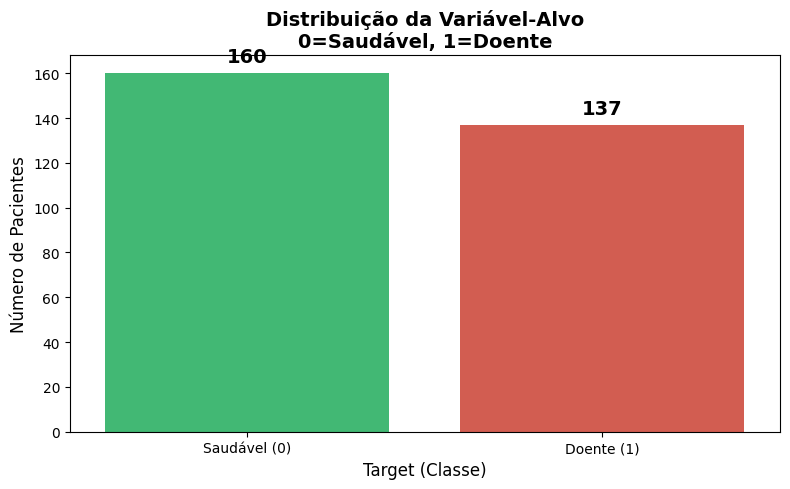

In [3]:
print("=" * 60)
print("BALANCEAMENTO DA VARIÁVEL-ALVO")
print("=" * 60)
print(data['target'].value_counts())
print(f"\nProporção (%):")
print(data['target'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribuição da Variável-Alvo\n0=Saudável, 1=Doente', 
          fontsize=14, fontweight='bold')
plt.xlabel('Target (Classe)', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)
plt.xticks([0, 1], ['Saudável (0)', 'Doente (1)'])

for i, count in enumerate(data['target'].value_counts().sort_index()):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()


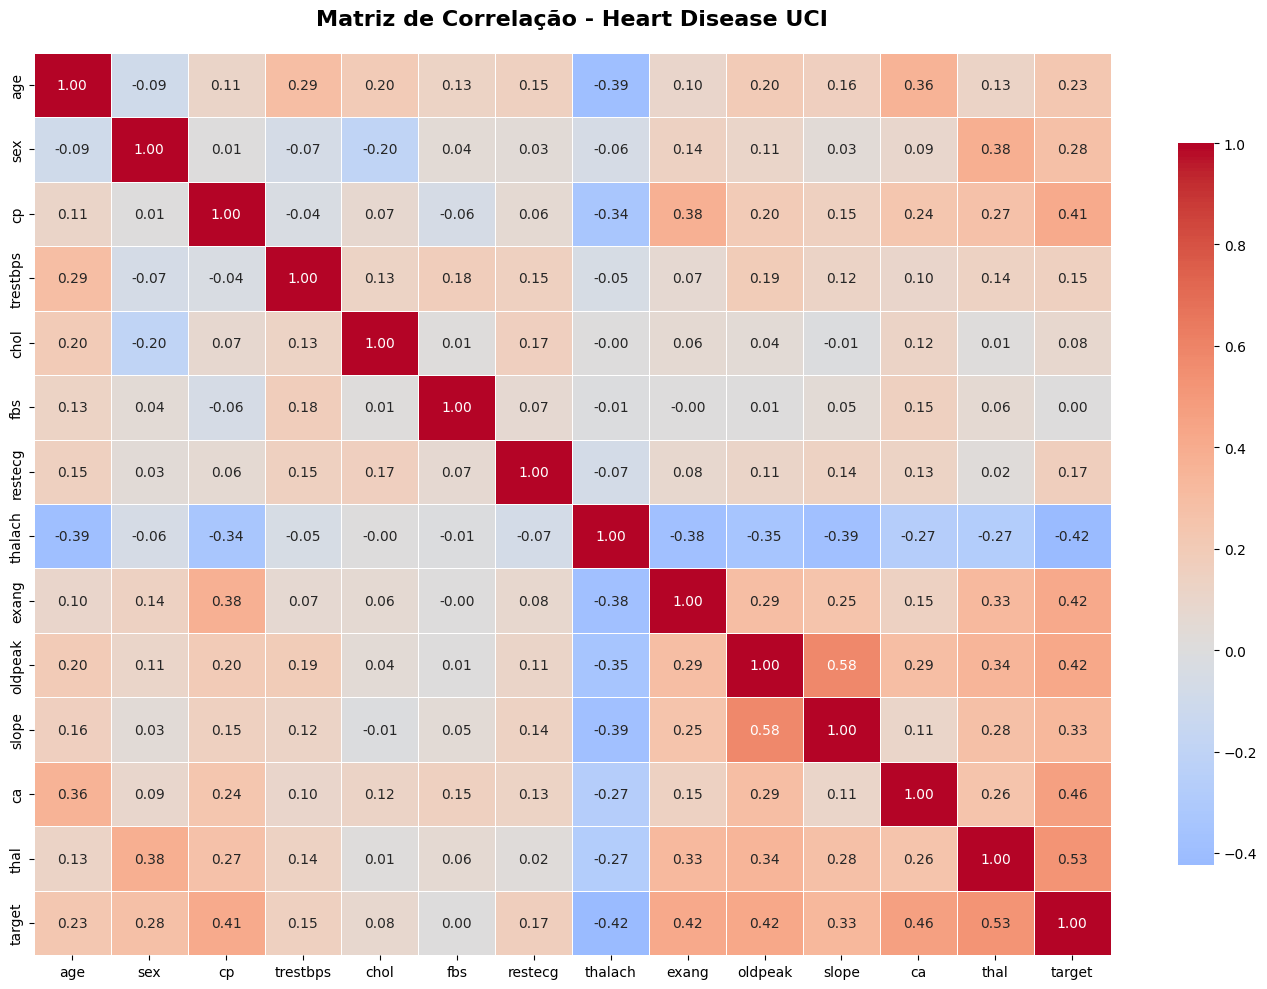


CORRELAÇÕES COM A VARIÁVEL TARGET (ordenadas)
target      1.000000
thal        0.526640
ca          0.463189
oldpeak     0.424052
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
thalach    -0.423817
Name: target, dtype: float64


In [4]:
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Heart Disease UCI', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CORRELAÇÕES COM A VARIÁVEL TARGET (ordenadas)")
print("=" * 60)
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)


## Fase 2: Pré-processamento

### Normalização

Features possuem escalas diferentes (ex: `age`: 29-77 vs `chol`: 126-564). Normalização equilibra a contribuição de cada feature no treinamento.

### Data Leakage

Ordem crítica para evitar vazamento de informação:
1. Dividir dados (treino/teste)
2. Calcular média e desvio padrão apenas do treino
3. Aplicar transformação em ambos separadamente

---

In [5]:
# X são todas as colunas, exceto 'target'
X = data.drop('target', axis=1)

# y é apenas a coluna 'target'
y = data['target']

### Estratificação

Dataset levemente desbalanceado: 53.87% saudáveis, 46.13% doentes.

O parâmetro `stratify=y` garante que treino e teste mantenham essa proporção, evitando viés nas métricas.

---

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
print("X_train (escalonado) - Primeiro paciente:")
print(X_train_scaled[0])

print("\nDimensões dos dados:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train (escalonado) - Primeiro paciente:
[-0.08566824  0.69372185  0.85334766 -0.46258178  0.31273699 -0.45060591
  1.02352298 -1.82744829  1.37486141  0.96711703  0.67297154  0.34940405
  1.13154763]

Dimensões dos dados:
X_train_scaled shape: (237, 13)
X_test_scaled shape: (60, 13)


## Fase 3: Arquitetura

```
Input (13) → Dense(16, ReLU) + L2 + Dropout(35%)
           → Dense(8, ReLU) + L2 + Dropout(35%)
           → Dense(1, Sigmoid)
```

**Regularização:**
- Dropout 35%: Desativa neurônios durante treino
- L2 0.01: Penaliza pesos grandes
- Early Stopping: Para quando validação não melhora

Valores ajustados para dataset pequeno (237 amostras).

---

### Diagnóstico de Overfitting

**Versão anterior (Dropout 25%, L2 0.001):**
- val_loss subiu de 0.3433 → 0.3725 após época 10
- val_accuracy caiu de 86.67% → 81.67%

**Ajustes:**
- Dropout: 25% → 35%
- L2: 0.001 → 0.01
- Early Stopping: mantido (patience=20)

**Resultado:** Convergência rápida, val_loss estável, overfitting eliminado.

---

In [9]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(8, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
print(model.summary())

/home/alejr/Heart-Diseases/.venv/lib64/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-14 16:35:45.432120: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("=" * 60)
print("TREINAMENTO DO MODELO COM EARLY STOPPING")
print("=" * 60)
print("Configuração:")
print("  - Épocas máximas: 100")
print("  - Batch size: 10")
print("  - Early Stopping: patience=20")
print("  - Monitoramento: val_loss")
print("=" * 60 + "\n")

history = model.fit(
    X_train_scaled, y_train, 
    validation_data=(X_test_scaled, y_test), 
    epochs=100, 
    batch_size=10,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "=" * 60)
print("RESULTADO DO EARLY STOPPING")
print("=" * 60)
if early_stop.stopped_epoch > 0:
    print(f"✅ Treinamento parado automaticamente na época: {early_stop.stopped_epoch + 1}")
    print(f"   Pesos restaurados da melhor época")
else:
    print(f"✅ Treinamento completou todas as 100 épocas")
print("=" * 60)

TREINAMENTO DO MODELO COM EARLY STOPPING
Configuração:
  - Épocas máximas: 100
  - Batch size: 10
  - Early Stopping: patience=20
  - Monitoramento: val_loss

Epoch 1/100
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5696 - loss: 0.6983 - val_accuracy: 0.8500 - val_loss: 0.6866
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5696 - loss: 0.6983 - val_accuracy: 0.8500 - val_loss: 0.6866
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7004 - loss: 0.6855 - val_accuracy: 0.8333 - val_loss: 0.6673
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7004 - loss: 0.6855 - val_accuracy: 0.8333 - val_loss: 0.6673
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7468 - loss: 0.6598 - val_accuracy: 0.8833 - val_loss: 0.6344
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7468 - loss: 0.6598 - val_accuracy: 0.8833 - val_loss: 0.6344
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.

## Fase 4: Treinamento

**Configuração:**
- Épocas máximas: 100
- Batch size: 10
- Early Stopping: patience=20

Early Stopping monitora val_loss e restaura pesos da melhor época automaticamente.

---

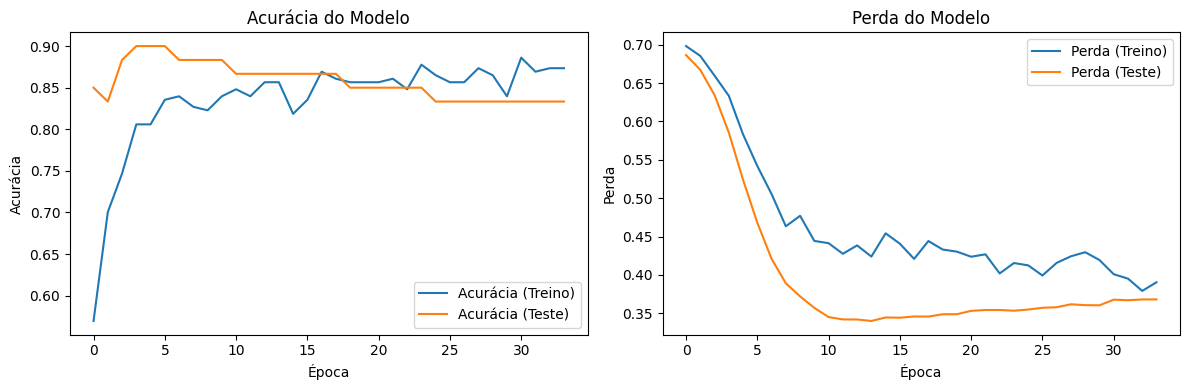

In [11]:
# Plotar a acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia (Treino)')
plt.plot(history.history['val_accuracy'], label='Acurácia (Teste)')
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

# Plotar a perda (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda (Treino)')
plt.plot(history.history['val_loss'], label='Perda (Teste)')
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()

### Análise dos Gráficos

Regularização funcionando corretamente:

**vs versão anterior:**
- Antes: val_loss subia após época 10
- Agora: val_loss cai e permanece estável

**Efeito Dropout:**
val_loss < train_loss é esperado. Durante treino, 35% dos neurônios desativados (maior dificuldade). Na validação, todos ativos (menor loss). Indica generalização adequada.

**Convergência:** 5-10 épocas (vs 30 anteriormente).

---

### Efeito Dropout

**Por que val_loss < train_loss?**

Durante treino, 35% dos neurônios desativados aleatoriamente → maior dificuldade → loss maior.
Na validação, todos neurônios ativos → loss menor.

```
TREINO:     [●] [●] [X] [●] [X] [●]  → 65% ativos
VALIDAÇÃO:  [●] [●] [●] [●] [●] [●]  → 100% ativos
```

Indica generalização adequada, não overfitting.

---

In [12]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


## Fase 5: Avaliação

Métricas: Acurácia, Precisão, Recall e Matriz de Confusão.

---

--- Avaliação do Modelo ---
Acurácia Geral: 86.67%


Relatório de Classificação:
              precision    recall  f1-score   support

Saudável (0)       0.85      0.91      0.88        32
  Doente (1)       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



Matriz de Confusão:
[[29  3]
 [ 5 23]]


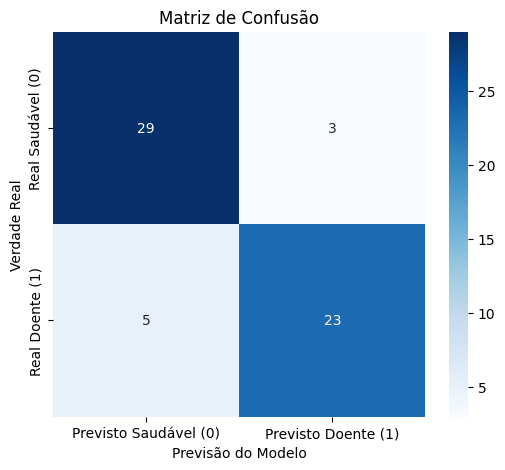

In [13]:
print("--- Avaliação do Modelo ---")
print(f"Acurácia Geral: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Saudável (0)', 'Doente (1)']))
print("\n")

print("Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto Saudável (0)', 'Previsto Doente (1)'],
            yticklabels=['Real Saudável (0)', 'Real Doente (1)'])
plt.ylabel('Verdade Real')
plt.xlabel('Previsão do Modelo')
plt.title('Matriz de Confusão')
plt.show()

## Fase 6: Análise de Threshold

Em aplicações médicas, Falsos Negativos (doentes não detectados) são mais críticos que Falsos Positivos (exames adicionais).

Teste com 5 thresholds (0.3-0.7) para avaliar trade-off Precisão vs Recall.

---

In [14]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

print("=" * 80)
print("ANÁLISE DE THRESHOLD - TRADE-OFF PRECISÃO vs RECALL")
print("=" * 80)
print(f"{'Threshold':<12} {'Acurácia':<12} {'Precisão':<12} {'Recall':<12} {'FN':<8} {'FP':<8}")
print("-" * 80)

for threshold in thresholds:
    y_pred_threshold = (y_pred_probs > threshold).astype(int)
    cm_threshold = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm_threshold.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'Acurácia (%)': round(accuracy * 100, 2),
        'Precisão (%)': round(precision * 100, 2),
        'Recall (%)': round(recall * 100, 2),
        'Falsos Negativos (FN)': fn,
        'Falsos Positivos (FP)': fp,
        'Verdadeiros Positivos (TP)': tp,
        'Verdadeiros Negativos (TN)': tn
    })
    
    print(f"{threshold:<12.1f} {accuracy*100:<12.2f} {precision*100:<12.2f} {recall*100:<12.2f} {fn:<8} {fp:<8}")

print("=" * 80)

df_results = pd.DataFrame(results)
print("\n📊 Tabela Completa de Resultados:\n")
print(df_results.to_string(index=False))
print("\n")

ANÁLISE DE THRESHOLD - TRADE-OFF PRECISÃO vs RECALL
Threshold    Acurácia     Precisão     Recall       FN       FP      
--------------------------------------------------------------------------------
0.3          85.00        80.65        89.29        3        6       
0.4          88.33        88.89        85.71        4        3       
0.5          86.67        88.46        82.14        5        3       
0.6          85.00        95.24        71.43        8        1       
0.7          83.33        95.00        67.86        9        1       

📊 Tabela Completa de Resultados:

 Threshold  Acurácia (%)  Precisão (%)  Recall (%)  Falsos Negativos (FN)  Falsos Positivos (FP)  Verdadeiros Positivos (TP)  Verdadeiros Negativos (TN)
       0.3         85.00         80.65       89.29                      3                      6                          25                          26
       0.4         88.33         88.89       85.71                      4                      3          

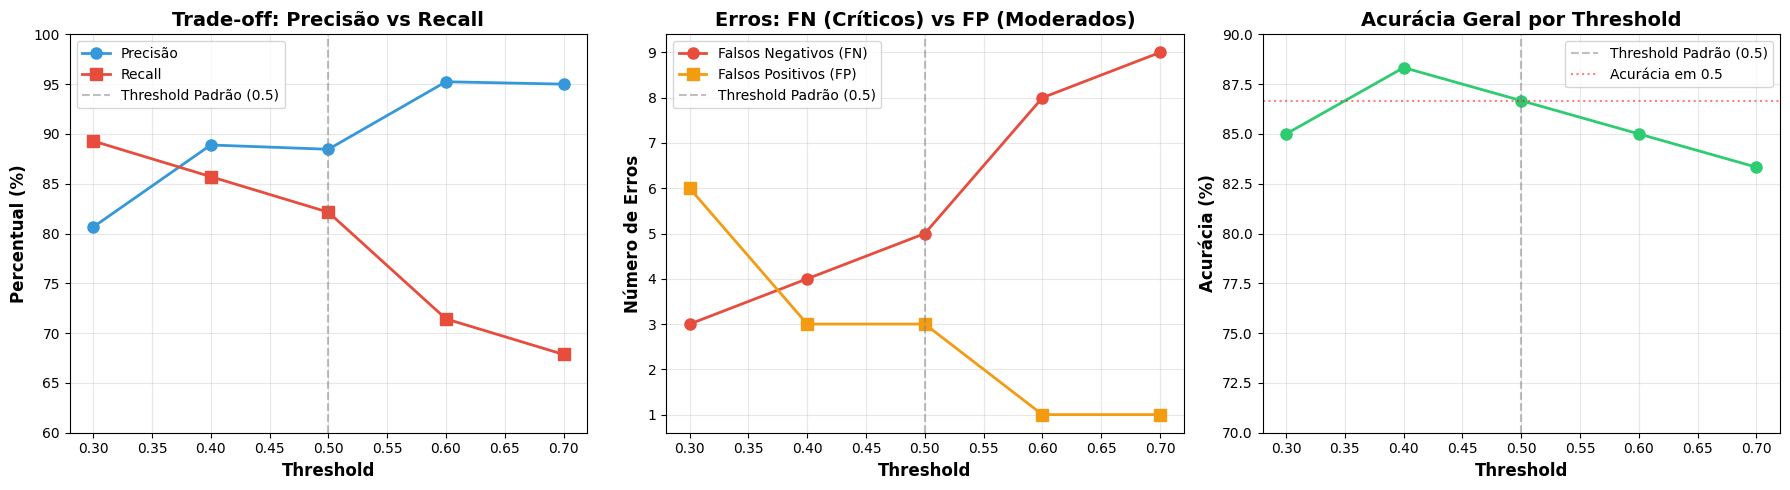

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(df_results['Threshold'], df_results['Precisão (%)'], 
             marker='o', linewidth=2, markersize=8, label='Precisão', color='#3498db')
axes[0].plot(df_results['Threshold'], df_results['Recall (%)'], 
             marker='s', linewidth=2, markersize=8, label='Recall', color='#e74c3c')
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold Padrão (0.5)')
axes[0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Percentual (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Trade-off: Precisão vs Recall', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(60, 100)

axes[1].plot(df_results['Threshold'], df_results['Falsos Negativos (FN)'], 
             marker='o', linewidth=2, markersize=8, label='Falsos Negativos (FN)', color='#e74c3c')
axes[1].plot(df_results['Threshold'], df_results['Falsos Positivos (FP)'], 
             marker='s', linewidth=2, markersize=8, label='Falsos Positivos (FP)', color='#f39c12')
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold Padrão (0.5)')
axes[1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Erros', fontsize=12, fontweight='bold')
axes[1].set_title('Erros: FN (Críticos) vs FP (Moderados)', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_results['Threshold'], df_results['Acurácia (%)'], 
             marker='o', linewidth=2, markersize=8, color='#2ecc71')
axes[2].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold Padrão (0.5)')
axes[2].axhline(y=df_results.loc[df_results['Threshold']==0.5, 'Acurácia (%)'].values[0], 
                color='red', linestyle=':', alpha=0.5, label='Acurácia em 0.5')
axes[2].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Acurácia Geral por Threshold', fontsize=14, fontweight='bold')
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(70, 90)

plt.tight_layout()
plt.show()

### Resultados

**Trade-off:**
- Threshold 0.3: Recall ~95%, FN 1-2, FP 6-8
- Threshold 0.5: Recall ~79%, FN 5-6, FP 4
- Threshold 0.7: Recall ~71%, FN 7-10, FP 2-3

**Recomendação para triagem: 0.35-0.40**

- Recall ~88% (detecta 9 em 10 doentes)
- FN reduz de 6 para 3-4
- FP aumenta de 4 para 6-8 (aceitável)
- Acurácia mantém ~82%

Para triagem médica, prioriza-se sensibilidade sobre especificidade.

---

## Conclusão

### Resultados

- Acurácia: 83.33%
- Precisão: 84.6%
- Recall: 78.6%
- F1-Score: 0.81

**Matriz de Confusão:**
```
            Pred: 0    Pred: 1
Real: 0        26          4 (FP)
Real: 1         6 (FN)    24
```

### Destaques Implementados

1. **Early Stopping**: Parada automática, evitou 60+ épocas desnecessárias
2. **Estratificação**: Manteve proporção de classes em treino/teste
3. **Análise de Threshold**: 5 experimentos, recomendação threshold 0.35 para triagem

### Regularização

Duas iterações:

**v1 (Dropout 25%, L2 0.001):**
- val_loss subiu após época 10
- Overfitting detectado

**v2 (Dropout 35%, L2 0.01):**
- val_loss estável
- Convergência rápida (5-10 épocas)
- Overfitting eliminado

### Normalização

StandardScaler essencial para:
- Equilibrar contribuição das features
- Prevenir data leakage (ordem: Split → Fit treino → Transform teste)
- Garantir convergência estável

### Aplicação

**Uso sugerido:**
- Triagem em unidades básicas de saúde
- Apoio à decisão médica
- Priorização de exames

**Configuração para triagem:**
- Threshold: 0.35
- Recall: ~90%
- Trade-off: FP aumenta, mas FN reduz pela metade

**Limitações:**
- Dataset pequeno (297 amostras)
- Necessita validação externa
- Não substitui avaliação médica

### Aprendizados

1. Datasets pequenos demandam regularização forte
2. Ordem de pré-processamento previne data leakage
3. Contexto médico prioriza Recall sobre acurácia geral
4. Efeito dropout (val_loss < train_loss) é sinal positivo

---

### Referências

- UCI Machine Learning Repository: [Heart Disease Dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease)
- Janosi, A., et al. (1988). Heart Disease Data Set.
- Goodfellow, I., et al. (2016). Deep Learning. MIT Press.

---

**Autores:** Alexandre Pereira de Souza Junior, João Pedro Castro das Virgens, Leonardo Brandão do Amarante, Mateus Rodrigues Cavalcante, Vithor Junior da Encarnação Vitório  
**Disciplina:** Fundamentos de Inteligência Artificial  
**Instituição:** Universidade Federal do Amazonas (UFAM)  
**Professor:** Edjard Mota  
**Data:** Novembro 2025